# PREDICTING HEART DISEASE

The goal of this project is to build a model that accurately predicts the likelihood of a new patient having heart disease in the future. We are to use the dataset https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction that contains anonymized data from multiple hospitals on several patients.

Each patient has the following information collected about them:

Age: age of the patient [years]
Sex: sex of the patient [M: Male, F: Female]
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
HeartDisease: output class [1: heart disease, 0: Normal]

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

%matplotlib inline

In [179]:
# Reading the data set into a dataframe and exploring it
heart = pd.read_csv("heart_disease_prediction.csv")
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [180]:
print(heart.shape)
heart.info()

(918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


There are 12 features and 918 observations in the dataset. 7 of the features are categorical (including FastingBS and HeartDisease).

In [181]:
#Exploring numerical features
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


There are no missing values in any column.
The average age of the patients is about 53, thae oldest patient was 77 and the youngest 28.
The minimum value for both RestingBP and Cholesterol is 0. It's not possible to have a BP of 0, unless dead. So there seems to be incorrect values in the RestingBP column as well as the Cholesterol column.

In [182]:
# Number of missing values in all columns
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

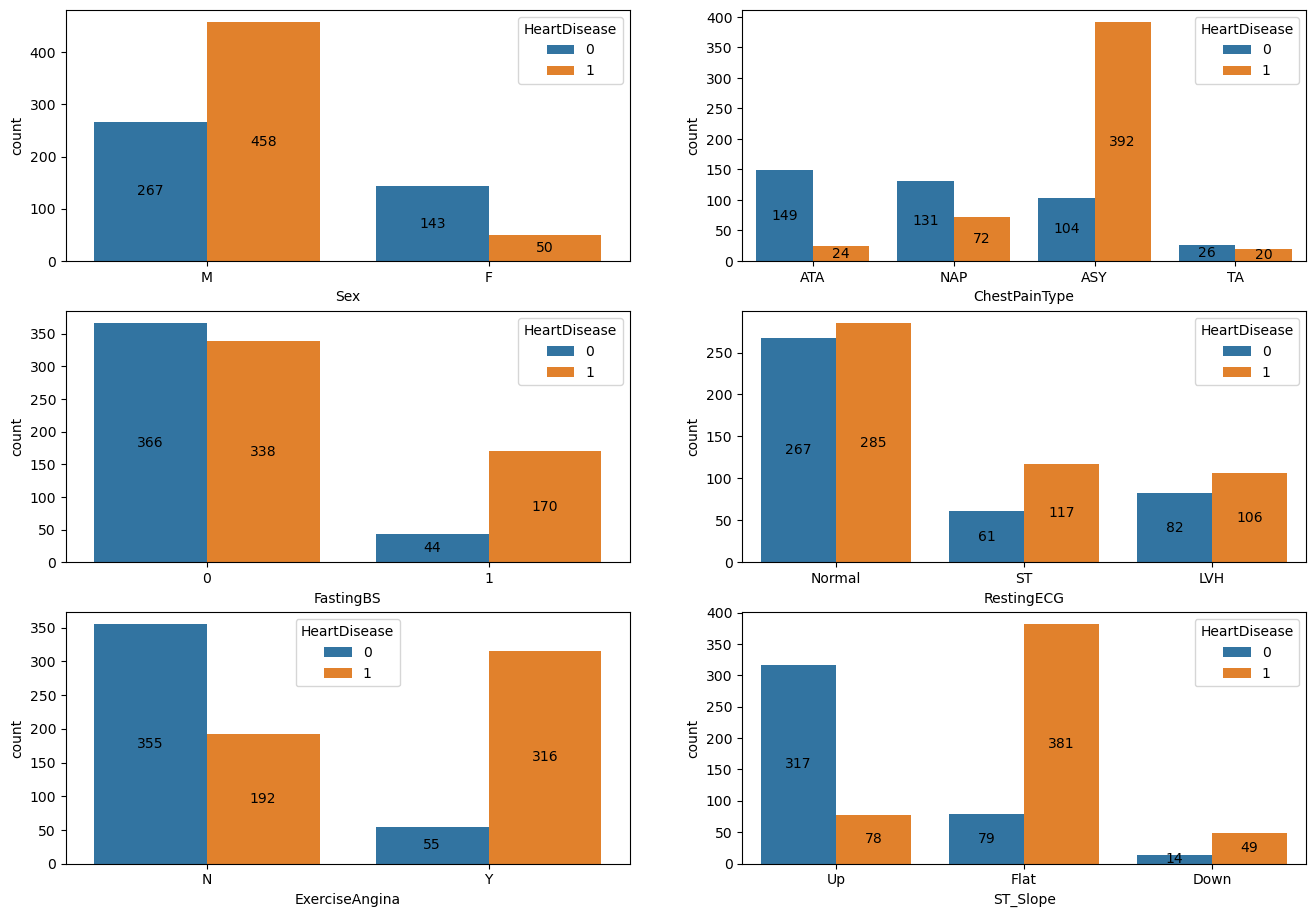

In [183]:
# bar chart that displays the number of rows for each category of that column, grouped by HeartDisease.
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=heart[col], hue=heart["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

Males were about 2.5 times the number of women in the dataset. Majority of the men had heart disease while majority women didn't.
The asymptomatic chest pain type had a higher incidence of heart disease.
Those with normal ECG had about a half probability of having a heart disease.
Those with blood sugar levels greater than 120mg/dl were more likely to have heart disease than those without.
Being Male, with asymptomatic chest pain type, with exercise angina and a flat ST_Slope may be key indicators of heart disease in this population

In [184]:
# Percentage of patients with heart disease are male and over 50 years old
heart_disease = heart[heart['HeartDisease'] == 1]
heart_male = heart_disease[heart_disease['Sex'] == 'M']
heart_male_over50 = heart_male[heart_male['Age'] > 50]
percentage = len(heart_male_over50) / len(heart) * 100
print(f"{percentage:.2f}% of patients with heart disease are male and over 50 years old")

37.47% of patients with heart disease are male and over 50 years old


In [185]:
# Median age of patients who were diagnosed with heart disease
median_age = heart_disease['Age'].median()
print(f"{median_age} is the median age of patients with heart disease")

57.0 is the median age of patients with heart disease


## DATA CLEANING

In [186]:
# Number of rows with a value of 0 for Resting BP and for Cholesterol
print(f"There is {len(heart[heart['RestingBP'] == 0])} row with a RestingBP of 0")
print(f"There are {len(heart[heart['Cholesterol'] == 0])} rows with a Cholesterol value of 0")

There is 1 row with a RestingBP of 0
There are 172 rows with a Cholesterol value of 0


In [187]:
# Replacing above rows with median values of corresponding column.
median_bp = heart['RestingBP'].median()
median_chol = heart['Cholesterol'].median()
heart['RestingBP'] = heart['RestingBP'].apply(lambda x: median_bp if x == 0 else x)
heart['Cholesterol'] = heart['RestingBP'].apply(lambda x: median_chol if x == 0 else x)

## FEATURE SELECTION

Based on the EDA above, I'll use the following features for the model;
Age, Sex, RestingBP, Cholesterol, FastingBS, ExerciseAngina, ST_Slope

In [188]:
heart_clean = heart[["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "ExerciseAngina", "ST_Slope", "HeartDisease"]]
heart_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   ExerciseAngina  918 non-null    object 
 7   ST_Slope        918 non-null    object 
 8   HeartDisease    918 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 64.7+ KB


In [189]:
# Converting the categorical features into dummy variables.
heart_clean = pd.get_dummies(data = heart_clean, drop_first = True)
heart_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    float64
 2   Cholesterol        918 non-null    float64
 3   FastingBS          918 non-null    int64  
 4   HeartDisease       918 non-null    int64  
 5   Sex_M              918 non-null    uint8  
 6   ChestPainType_ATA  918 non-null    uint8  
 7   ChestPainType_NAP  918 non-null    uint8  
 8   ChestPainType_TA   918 non-null    uint8  
 9   ExerciseAngina_Y   918 non-null    uint8  
 10  ST_Slope_Flat      918 non-null    uint8  
 11  ST_Slope_Up        918 non-null    uint8  
dtypes: float64(2), int64(3), uint8(7)
memory usage: 42.3 KB


In [190]:
# Investigating the correlations between colums
corr = abs(heart_clean.corr())
top_5_features = corr["HeartDisease"].sort_values(ascending = False)[1:6].index
top_5_features

Index(['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'ChestPainType_ATA',
       'Sex_M'],
      dtype='object')

<AxesSubplot:>

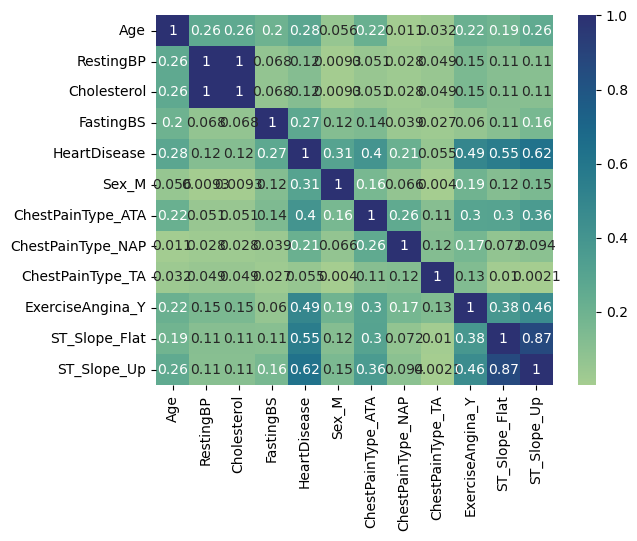

In [191]:
# Finding Correlations using the heat map method
sns.heatmap(corr, annot = True, cmap = "crest")

From both the heat map the corr method, the features that are resonably correlated are ST_Sloe_Up, ST_Slope_Flat, ExerciseAngina_Y, ChestPainType_ATA and Sex_M

## BUILDING A CLASSIFIER WITH ONE FEATURE

In [192]:
# Splitting the data
X = heart_clean.drop("HeartDisease", axis = 1)
y = heart_clean["HeartDisease"]

# Splitting into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 222)

accuracies = {}
for feature in top_5_features:
    knn = KNeighborsClassifier(n_neighbors = 9)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    accuracies[feature] = round(accuracy, 2) * 100
print("Below is a dict of features and corresponding accuracies using KNeighbors classifier")
print(accuracies)

Below is a dict of features and corresponding accuracies using KNeighbors classifier
{'ST_Slope_Up': 80.0, 'ST_Slope_Flat': 76.0, 'ExerciseAngina_Y': 78.0, 'ChestPainType_ATA': 68.0, 'Sex_M': 51.0}


The model trained on the ST_Slope_Up feature performed the best.
The models trained on Sex_M underperformed. 

## BUILDING A CLASSIFIER WITH MULTIPLE FEATURES

In [193]:
# Normalizing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[top_5_features])
X_val_scaled = scaler.transform(X_val[top_5_features])

# Creating, training and evaluating the model using the scaled data
k_nn = KNeighborsClassifier(n_neighbors = 9)
k_nn.fit(X_train_scaled, y_train)
accuracy = k_nn.score(X_val_scaled, y_val)
print(f"The accuracy of the model trained on multiple features is {accuracy*100:.2f}%")

The accuracy of the model trained on multiple features is 84.24%


The model trained on multiple features performed better than all the previous models trained on one feature only, with about 3 percentage points higher than the best one.

## HYPERPARAMETER TUNING

In [194]:
# Using GridSearchCV

# Note: Data has already been split into X and y earlier.
# Splitting data further into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 222)

# Normalizing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[top_5_features])
hyperparams = {
    "n_neighbors": range(1, 10),
    "p": (1, 6),
    "weights": ("uniform", "distance"),
    "metric": ["minkowski", "manhattan"]
}
knn = KNeighborsClassifier()
gridsearch = GridSearchCV(estimator = knn, param_grid = hyperparams, scoring = "accuracy")
gridsearch.fit(X_train_scaled, y_train)
best_score = gridsearch.best_score_
print(f"The best score obtained using GridSearchCV is {best_score * 100:.2f}%")
best_params = gridsearch.best_params_
print(f"The parameter setting that gave the best results is {best_params}")

The best score obtained using GridSearchCV is 83.38%
The parameter setting that gave the best results is {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


The accuracy of the model using GridSearchCV was just slightly less than the previous one with multiple features, less by 1 percentage point.

## MODEL EVALUATION ON THE TEST SET

In [195]:
# Normalizing the X_test data
X_test_scaled = scaler.transform(X_test[top_5_features])

# Evaluating the model on the test set
prediction = gridsearch.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, prediction)
print(f"The accuracy of the model's prediction is {accuracy * 100:.2f}%")

The accuracy of the model's prediction is 86.41%


The model is likely to predict the patient's risk of heart disease 86% of the time.

Potential improvements to the performance;
    Try out different combinations of features
    Increase the sample size or change the population
    Try out different combinations of hyperparameters.

The advantages of the model in real-world healthcare setting;
    It offers a fast method of predicting risk which could aid diagnostics
    
The disadvantages of using this model in real-world healthcare setting;
    Despite a fairly high accuracy of 86%. In practice it is still low, because 13% of the time,
    it will return a false negative result which could turn out dangerous.